In [29]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
import pytesseract

#set the tessaract_cmd path to tessaract.exe
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ramon.koller\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

# Find the Sudoku in the picture

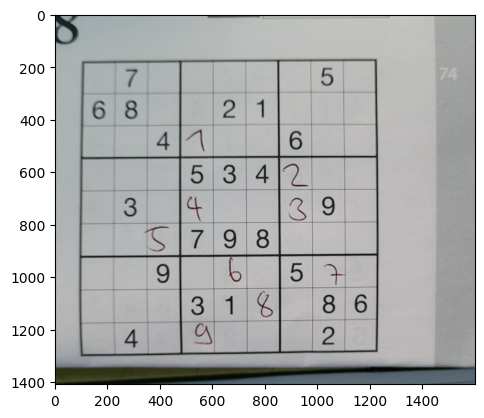

In [30]:
img = cv2.imread('data/own/6.jpg')
plt.imshow(img)

In [31]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 3)
rm_noise = cv2.medianBlur(blurred, 3)

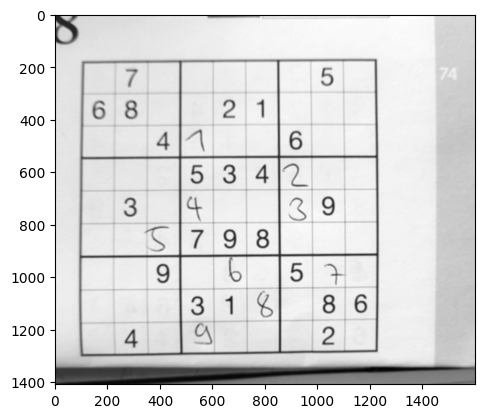

In [32]:
plt.imshow(rm_noise, cmap='gray')

In [33]:
thresh = cv2.adaptiveThreshold(rm_noise, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
thresh = cv2.bitwise_not(thresh)

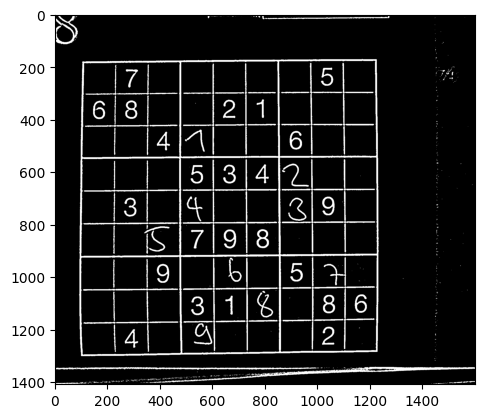

In [34]:
plt.imshow(thresh, cmap='gray')


In [35]:
contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

In [36]:
for c in contours:
    perimeter = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.05 * perimeter, True)
    if len(approx) == 4:
        field = approx
        break

In [37]:
sudoku = four_point_transform(img, field.reshape(4, 2))

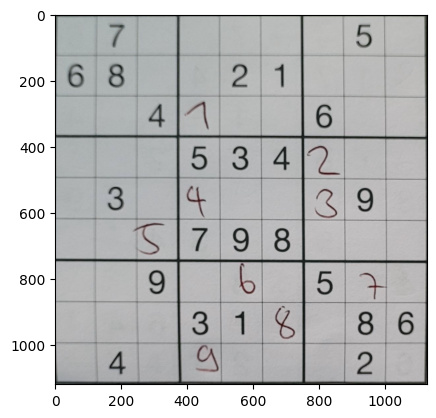

In [38]:
plt.imshow(sudoku)

# Process every cell

In [39]:
def filter_digit(cell):
    cell_gray = cv2.cvtColor(cell, cv2.COLOR_RGB2GRAY)
    thresh = cv2.threshold(cell_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    (h, w) = thresh.shape

    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    if len(contours) == 0:
        return None
    
    d = max(contours, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [d], -1, 255, -1)

    percent = cv2.countNonZero(mask) / float(w * h)
    if percent < 0.02:
        return None
    
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    digit = cv2.resize(digit, (28, 28))
    return digit

### the function below shows every processed cell where a digit should be

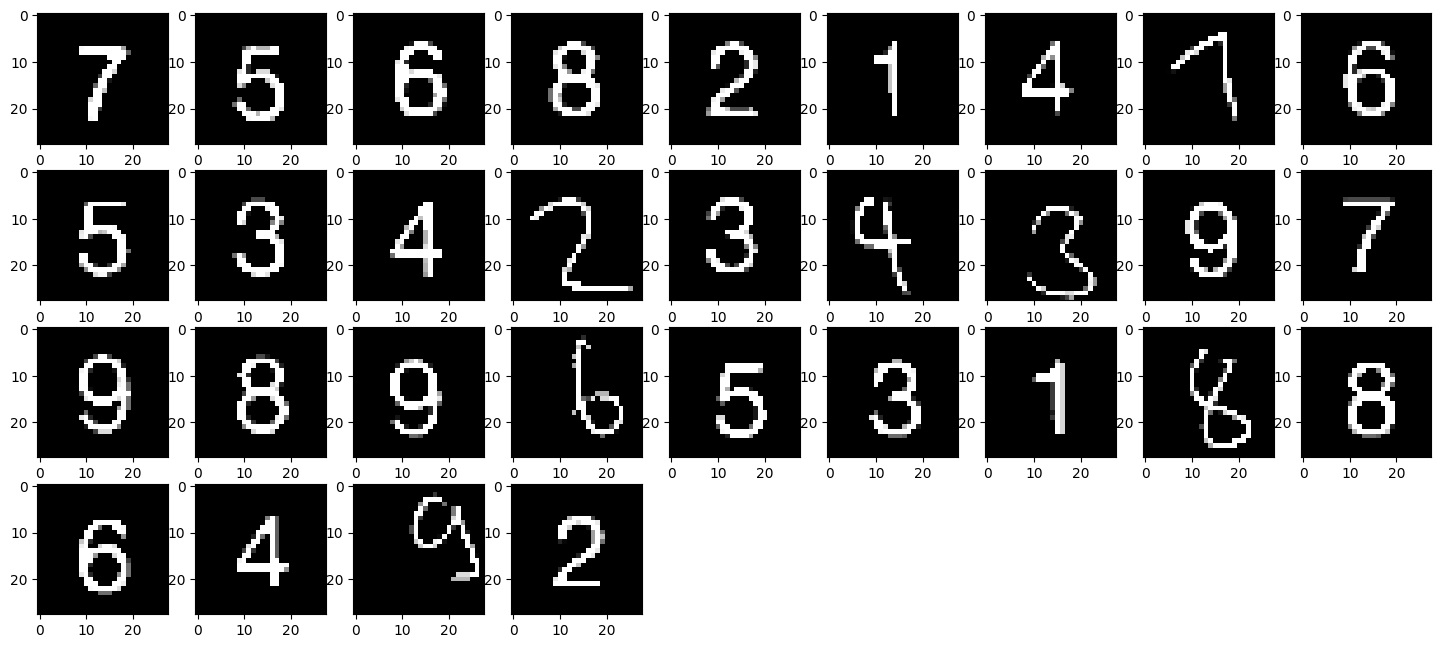

In [40]:
cell_breite = sudoku.shape[0] // 9
cell_hoehe = sudoku.shape[1] // 9

plt.figure (figsize = (18, 18))

sudoku = four_point_transform(img, field.reshape(4, 2))

a = 1

for i in range(9):
    for j in range(9):
        value = filter_digit(sudoku[i * cell_breite: (i + 1) * cell_breite, j * cell_hoehe:(j + 1) * cell_hoehe])
        
        if value is None:
            continue
        else:
            plt.subplot (9, 9, a)
            
            plt.imshow(value, cmap='gray')
        
            a += 1

## This function is only for empty sudokus where no handwritten digits appears

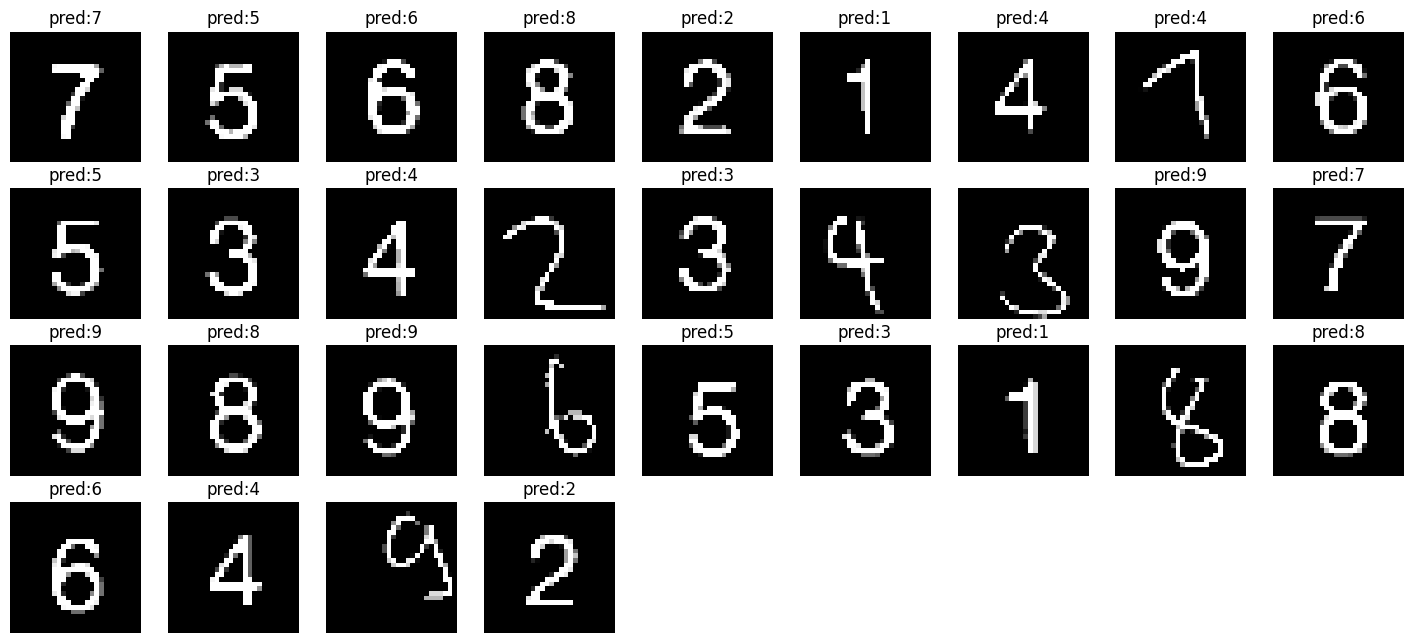

In [41]:
cell_breite = sudoku.shape[0] // 9
cell_hoehe = sudoku.shape[1] // 9

plt.figure (figsize = (18, 18))

sudoku = four_point_transform(img, field.reshape(4, 2))

a = 1

cells = np.zeros((9, 9))

for i in range(9):
    for j in range(9):
        value = filter_digit(sudoku[i * cell_breite: (i + 1) * cell_breite, j * cell_hoehe:(j + 1) * cell_hoehe])
        
        if value is None:
            continue
        else:
            plt.subplot (9, 9, a)

            thresh = value
            #thresh = cv2.threshold(value, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
            
            plt.imshow(thresh, cmap='gray')
            plt.axis('off')
            
            #config = '--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789'
            config = '--psm 10 --dpi 70 -c tessedit_char_whitelist=0123456789'
            text = pytesseract.image_to_string(thresh, config=config)

            #print(text.strip())

            if text.strip():
                cells[i][j] = (int(text.strip()))
                cv2.putText(sudoku, text.strip(), (j * cell_hoehe + int(cell_hoehe / 3), i * cell_breite + int(cell_breite * 0.8)), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 6, 2)
                plt.title("pred:" + text.strip())
            a += 1


### we see that some times he recognizes handwritten digits who could be wrong. Now we have to filter them out

### print recognized digits

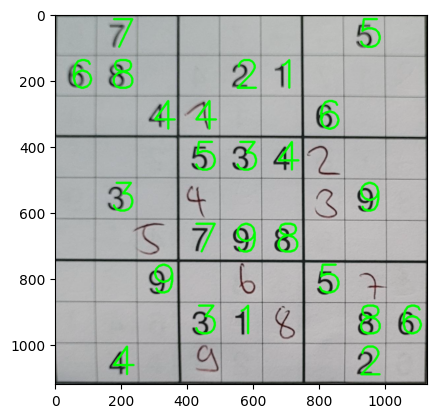

In [42]:
plt.imshow(sudoku)

# Digital or handwritten Classifier

## load classificatin model

In [43]:
import torch
    
class HandwrittenDetectionModel2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding=1), torch.nn.BatchNorm2d(32), torch.nn.ReLU(), torch.nn.Dropout(0.5))
        self.conv2 = torch.nn.Sequential(torch.nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1), torch.nn.BatchNorm2d(64), torch.nn.ReLU(), torch.nn.MaxPool2d(kernel_size=2, stride=2), torch.nn.Dropout(0.5))
        self.linear = torch.nn.Sequential(torch.nn.Linear(64 * 14 * 14, 32), torch.nn.BatchNorm1d(32), torch.nn.ReLU(), torch.nn.Dropout(0.5), torch.nn.Linear(32, 1), torch.nn.Sigmoid())
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        out = self.linear(x.reshape(x.shape[0], -1))
        return out
    
model = HandwrittenDetectionModel2()
model

HandwrittenDetectionModel2(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=12544, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [44]:
model = torch.load('models/model_dig_hw')

### every cell is either handwritten or digital. Only the digital digits should be the inputs for tessaract

tensor([0.9990])
tensor([0.9998])
tensor([0.9999])
tensor([0.9999])
tensor([0.9999])
tensor([0.9999])
tensor([0.9999])
tensor([0.7230])
tensor([1.0000])
tensor([0.9997])
tensor([0.9999])
tensor([0.9992])
tensor([5.5679e-18])
tensor([1.0000])
tensor([5.3398e-13])
tensor([3.1948e-17])
tensor([0.9999])
tensor([1.0000])
tensor([0.9994])
tensor([1.0000])
tensor([0.9999])
tensor([4.2459e-16])
tensor([0.9999])
tensor([0.9999])
tensor([0.9993])
tensor([3.1619e-29])
tensor([1.0000])
tensor([1.0000])
tensor([1.0000])
tensor([8.2752e-26])
tensor([1.0000])


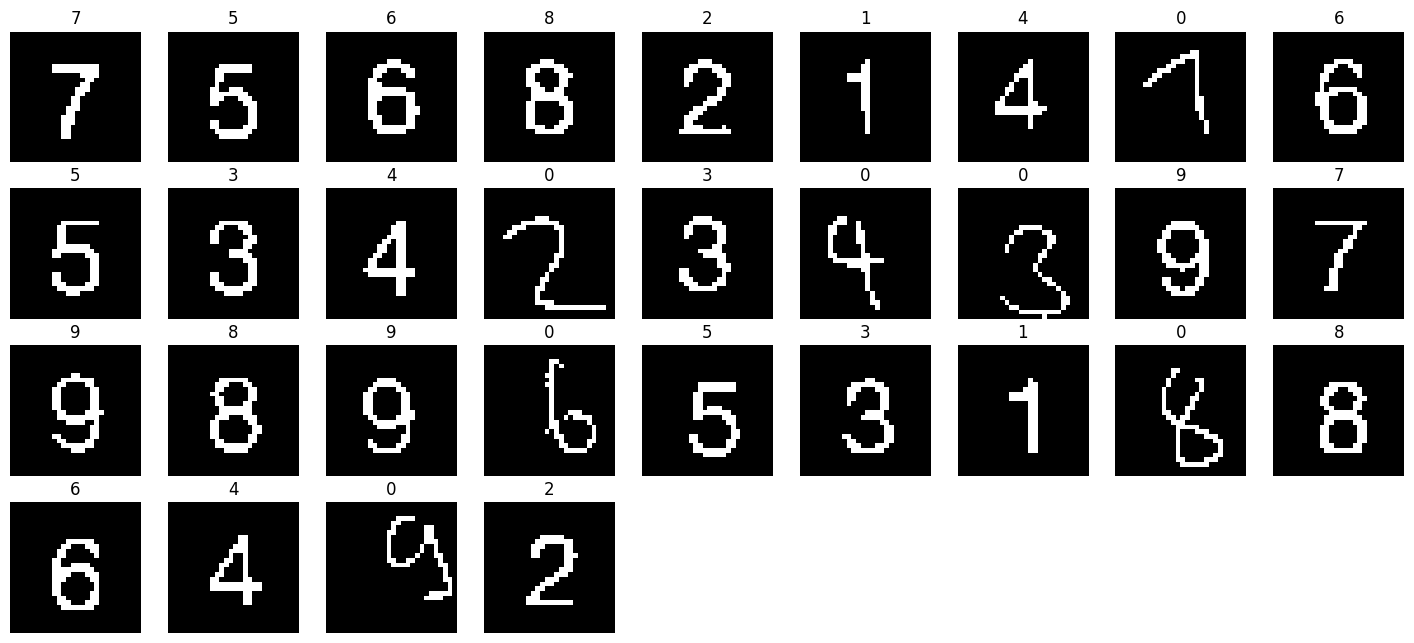

In [45]:
import torchvision

cell_breite = sudoku.shape[0] // 9
cell_hoehe = sudoku.shape[1] // 9

plt.figure (figsize = (18, 18))

sudoku = four_point_transform(img, field.reshape(4, 2))

a = 1

cells = np.zeros((9, 9))

for i in range(9):
    for j in range(9):
        value = filter_digit(sudoku[i * cell_breite: (i + 1) * cell_breite, j * cell_hoehe:(j + 1) * cell_hoehe])
        
        if value is None:
            continue
        else:
            plt.subplot (9, 9, a)
            plt.axis('off')

            thresh = value
            thresh = cv2.threshold(value, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

            model.eval()
            gray_tensor = torch.from_numpy(thresh / 255)
            gray_tensor = torch.unsqueeze(gray_tensor, 0)
            gray_tensor = torch.unsqueeze(gray_tensor, 0)
            gray_tensor = gray_tensor.to(torch.float32)
            plt.imshow(thresh, cmap='gray')
            with torch.no_grad():

                    outputs = model(gray_tensor)
                    
                    outputs = outputs.reshape(-1)
                    print(outputs)
            
            if outputs > 0.99:

                thresh = cv2.threshold(value, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

                config = '--psm 10 --dpi 70 -c tessedit_char_whitelist=0123456789'
                text = pytesseract.image_to_string(value, config=config)

                plt.title(text.strip())

                if text.strip():
                    cells[i][j] = (int(text.strip()))
            else:
                 plt.title(0)
            a += 1


In [56]:
cells

array([[0., 7., 0., 0., 0., 0., 0., 5., 0.],
       [6., 8., 0., 0., 2., 1., 0., 0., 0.],
       [0., 0., 4., 0., 0., 0., 6., 0., 0.],
       [0., 0., 0., 5., 3., 4., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0., 9., 0.],
       [0., 0., 0., 7., 9., 8., 0., 0., 0.],
       [0., 0., 9., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 3., 1., 0., 0., 8., 6.],
       [0., 4., 0., 0., 0., 0., 0., 2., 0.]])

# if a digit is wrong, we could change it manually

In [59]:
def change_digit(row, column, digit):
    global cells
    cells[row][column] = digit

In [62]:
#change_digit(0, 1, 3)

In [63]:
cells

array([[0., 3., 0., 0., 0., 0., 0., 5., 0.],
       [6., 8., 0., 0., 2., 1., 0., 0., 0.],
       [0., 3., 4., 0., 0., 0., 6., 0., 0.],
       [0., 0., 0., 5., 3., 4., 0., 0., 0.],
       [0., 3., 0., 0., 0., 0., 0., 9., 0.],
       [0., 0., 0., 7., 9., 8., 0., 0., 0.],
       [0., 0., 9., 0., 0., 0., 5., 0., 0.],
       [0., 0., 0., 3., 1., 0., 0., 8., 6.],
       [0., 4., 0., 0., 0., 0., 0., 2., 0.]])

# Solve the Sudoku

In [48]:
from ortools.sat.python import cp_model
import numpy as np

In [49]:
board = cells.astype(int)
board

array([[0, 7, 0, 0, 0, 0, 0, 5, 0],
       [6, 8, 0, 0, 2, 1, 0, 0, 0],
       [0, 0, 4, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 5, 3, 4, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 9, 0],
       [0, 0, 0, 7, 9, 8, 0, 0, 0],
       [0, 0, 9, 0, 0, 0, 5, 0, 0],
       [0, 0, 0, 3, 1, 0, 0, 8, 6],
       [0, 4, 0, 0, 0, 0, 0, 2, 0]])

In [50]:
solver_model = cp_model.CpModel()

variables = {}
incorrect_variables = {}
corrected_variables = {}

for i in range(9):
    variables[i] = {}
    for j in range(9):
        variables[i][j] = solver_model.NewIntVar(1, 9, 'digit_{}_{}'.format(i, j))
        if board[i][j] != 0:
            solver_model.Add(variables[i][j] == board[i][j])

In [51]:
for i in range(9):
    solver_model.AddAllDifferent([variables[i][j] for j in range(9)])

for j in range(9):
    solver_model.AddAllDifferent([variables[i][j] for i in range(9)])

for i in range(0, 9, 3):
    for j in range(0, 9, 3):
        solver_model.AddAllDifferent([variables[i + x][j + y] for x in range(3) for y in range(3)])

In [52]:
solver = cp_model.CpSolver()
status = solver.Solve(solver_model)

In [53]:
if status == cp_model.FEASIBLE or status == cp_model.OPTIMAL:
    result = np.zeros((9, 9)).astype(np.int)
    for i in range(9):
        for j in range(9):
            result[i][j] = int(solver.Value(variables[i][j]))
    print(result)
else:
    raise Exception('Unfeasible Sudoku')

[[9 7 1 6 8 3 2 5 4]
 [6 8 5 4 2 1 9 7 3]
 [3 2 4 9 7 5 6 1 8]
 [2 9 8 5 3 4 1 6 7]
 [4 3 7 1 6 2 8 9 5]
 [5 1 6 7 9 8 3 4 2]
 [8 6 9 2 4 7 5 3 1]
 [7 5 2 3 1 9 4 8 6]
 [1 4 3 8 5 6 7 2 9]]


C:\Users\ramon.koller\AppData\Local\Temp\ipykernel_4220\3919485960.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  result = np.zeros((9, 9)).astype(np.int)


# Visualize the Solution

In [54]:
sudoku = four_point_transform(img, field.reshape(4, 2))
for i in range(9):
    for j in range(9):
        cv2.putText(sudoku, str(result[i][j]), (j * cell_hoehe + int(cell_hoehe / 3), i * cell_breite + int(cell_breite * 0.8)), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 6, 2)


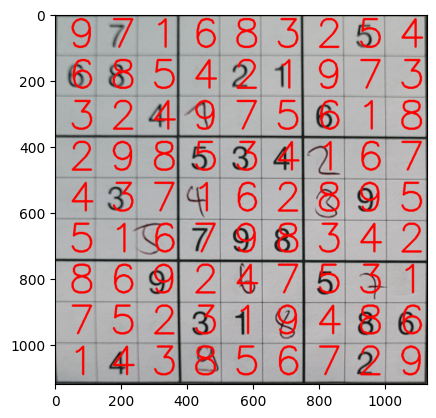

In [55]:
plt.imshow(sudoku)